# answers 05: a mixture of five
**Sean's answers**

I've downloaded Wiggins' data file [w05-data.tbl](w05-data.tbl) to my current directory.

## 1. reproduce Wiggins' K-means result

I'll define some functions that I need for k-means, then a function that implements k-means, then I'll call it on Wiggins' data. While I'm defining these functions, I also have an eye toward things I need for parts (2) and (3) of the p-set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

infile = "w05-data.tbl"

do_init_at_true = False          # An option we can set to initialize centroids to their known/true positions. Useful for debugging.
do_logspace_distance = False     # We'll set this to True when we get to part (3)

I'm not a huge fan of Pandas yet, so here's a basic Python function for reading in Wiggins' data.

In [2]:
def read_data(infile):
    """
    Parse Wiggins' data file. 
    Returns (ctype, data, N, G, Q):
       ctype[i]:  cell type 0..Q-1 for each cell i (0..N-1)
       data[i,g]: mapped read counts for each cell i, for each gene g
       N:         number of cells (rows of data)
       G:         number of genes (columns of data)
       Q:         number of cell types (true/known clusters)
    """
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue   # skip comment lines
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( [int(fields[2]), int(fields[3])])
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q

We'll initialize our centroids to some sort of random guess. Here's one way to do it: throw random points into the space encompassed by the data.

In [3]:
def sample_component(X):
    """
    Returns a random centroid position
    Input: X[i,g] = the actual data; we use this to determine the min/max in each dimension,
                    and we sample a random vector uniformly on each dimension within those bounds.
    """
    N, G   = np.shape(X)
    dmax   = np.amax(X, axis=0)
    dmin   = np.amin(X, axis=0)
    mu     = np.zeros(G)
    for g in range(G):
        mu[g] = np.exp(np.random.uniform(np.log(dmin[g]), np.log(dmax[g])))  
    return mu

Most fundamentally, K-means depends on calculating the Euclidean distance between a current centroid and a data point. So here's a function for calculating our distance. We get to define what space we calculate that distance in, and in part (3) of the problem we're going to calculate it in log(counts) space instead of (counts) space, with an option `do_logspace_distance`.

In [4]:
def euclidean_dist(v1, v2):
    """
    Return the euclidean distance || v1 - v2 ||.
    If do_logspace_distance is True, do || log(v1) - log(v2) || instead.
    """
    d = 0.
    for i in range(len(v1)):
        if do_logspace_distance:
            d += (np.log(v1[i]) - np.log(v2[i]))**2
        else:
            d += (v1[i] - v2[i])**2
    return np.sqrt(d)

At each K-means assignment step, we identify the current closest centroid for each data point. I'll make a function for that.

In [5]:
def closest_centroid(x, centroids):
    """
    Input:
       centroids[k,g] : the current centroid positions, for centroids k=0..K-1, dimensions/genes g=0..G-1
       x[g]:            one data point
    Returns best_k, best_dist:
       best_k         : index of the best centroid (0..K-1)
       best_d         : distance to the best centroid
    """
    K, dim = np.shape(centroids)
    best_k = 0
    best_dist = euclidean_dist(x, centroids[0])
    for k in range(1,K):
        dist = euclidean_dist(x, centroids[k])
        if dist < best_dist:
            best_k    = k
            best_dist = dist
    return best_k, best_dist


We use `closest_centroid()` to implement the k-means assignment step:


In [6]:
def assign_kmeans(X, centroids):
    """
    Input:
       X[i,g] are the data point
       centroids[k] are the current centroid positions
    Return assignments, totdist:
       assignments[i] assign each data point i to a cluster k
       tot_sqdist is the total squared distance, the k-means objective function
    """
    K, dim      = np.shape(centroids)
    N           = len(X)
    assignments = np.zeros(N).astype(int)
    tot_sqdist  = 0
    for i,x in enumerate(X):
        assignments[i], di = closest_centroid(x, centroids)
        tot_sqdist += di**2
    return assignments, tot_sqdist


Then in a K-means update step, we calculate new centroid positions, given assignments of data points to centroids. 

An important detail: it's possible for a centroid to die, receiving no assigned points. We have to be careful to catch this case (and avoid division by zero errors). 

In [7]:
def update_kmeans(X, assignments, K):
    """
    Input:
      X[i,g] are the data points; i=0..N-1,  g=0..G-1
      assignments[i] : which centroid (0..K-1) each point has just been assigned to
      K : how many centroids there are
    Returns:
      centroids[k,g] : updated centroid positions
      pk[k]          : frequency of using component k: how many points were assigned to it, normalized.
    """
    N, G    = np.shape(X)              
    
    centroids = np.zeros((K,G))        
    counts    = np.zeros(K)
    for i in range(N):
        counts[assignments[i]] += 1
        for g in range(G):
            centroids[assignments[i], g] += X[i][g]

    for k in range(K):
        if counts[k] > 0:                                      # In a K-means implementation we have to watch out for the case
            centroids[k] = np.divide(centroids[k], counts[k])  # where a centroid gets no assigned points. Avoid dividing by zero.
        else:                                                  # One strategy is to leave the centroid unchanged. 
            centroids[k] = sample_component(X)                 # Here, instead, we reinitialize it randomly.

    Z = np.sum(counts)
    counts = np.divide(counts, Z)
    return centroids, counts

We need to detect when the iterative algorithm has converged. The simplest thing to look at is whether any assignments were changed in the current iteration. If not, we have reached a stable answer.

In [8]:
def diff_assignments(a1, a2):
    """
    Returns the number of assignments that differ between <a1> and <a2>,
    where these are, e.g., a1[i] = 0..K-1, a cluster assignment for each cell i.
    """
    N     = len(a1)
    ndiff = 0
    for i in range(N):
        if a1[i] != a2[i]: 
            ndiff += 1
    return ndiff

Finally we're ready to implement the k-means algorithm itself. 

We have the routine return `tot_sqdist`, the total _squared_ Euclidean distance for data points to their assigned centroids. K-means is a local optimizer: we're going to have to run it many times and choose a "best" answer. `tot_sqdist` is our measure of "best". We can compare different runs of K-means using this as a metric, looking for a run that gives us the minimum squared distance. 

In [9]:
def kmeans(X, K, T=np.zeros(0)):
    """
    Input:
       X[i,g]:  data points i=0..N-1, each of which is a vector w/ g=0..G-1
       K     :  how many clusters to fit
       T[i]  :  OPTIONAL: known/true cluster assignments; initialize centroids on their true positions (debugging)
    Return (kp, centroids, assignments, totdist):
       kp[k] :  probability mass (# of data points) assigned to component k
       centroids[k,g] : locations of each cluster centroid
       assignments[i] : which centroid 0..K-1 that each data point i=0..N-1 is assigned to
       tot_sqdist:      total squared Euclidean distance for this k-means solution.
    """
    N, G = np.shape(X)
    
    if len(T) > 0:
        centroids, qp = update_kmeans(X, T, K)
    else:
        centroids = np.zeros((K,G))
        for k in range(K):
            centroids[k] = sample_component(X)
    
    iteration = 0
    while True:
        assignments, tot_sqdist = assign_kmeans(X, centroids)
        if iteration >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff == 0: 
                break
        centroids, kp   = update_kmeans(X, assignments, K)
        old_assignments = assignments
        iteration      += 1
    print("iterations = {}".format(iteration))

    kp = np.zeros(Q)
    for i in range(N):
        kp[assignments[i]] += 1
    kp = np.divide(kp, N)

    return kp, centroids, assignments, tot_sqdist

Almost ready - let's also define a function that uses matplotlib to visualize the clustering.

I'm going to allow this function to take an optional argument `<T>`, the true assignments, to produce a slightly enhanced visualization that compares a K-means clustering to the known answer. Alas, this frill forces us to do one extra step. The order of the centroids assigned by K-means is arbitrary; even if we found the exact same answer as the true assignments, the order of the clusters is permuted. So we define a function `correspondence()` that tries to find an unambiguous mapping between the true and K-means clusterings. For a bad clustering, this can fail, so it returns `is_mapped` for whether it succeeds or not.

In [10]:
def correspondence(T, C):
    """
    Try to establish a correspondence between the true assignments T[i] and a K-means assignment C[i],
    so we can compare. The problem is that the order of the centroids K is arbitrary, so we can't
    do this comparison directly. Look for an order that is unambiguously best.
    
    If we can find one, set <is_mapped> True, and map[qt] = k is the index in C that corresponds to true set <qt>.
    
    Return is_mapped, map.
    """
    N  = len(T)
    Q  = np.max(T) + 1
    assert len(C)        == N
    # assert np.max(C) + 1 == Q    # This is not necessarily true! Centroid Q-1 might have been assigned to no points.

    A = np.zeros((Q,Q)).astype(int)
    for i in range(N):
        A[ T[i], C[i] ] += 1

    map = np.zeros(Q).astype(int)
    for qt in range(Q):
        map[ np.argmax(A[qt]) ] = qt
    
    if len(set(map)) == Q:
        is_mapped = True
    else:
        is_mapped = False
    return is_mapped, map


ok, now the viz.

In [11]:
def visualize_data(data, centroids, C, T=np.zeros(0), outfile=None):
    N, G  = np.shape(data)
    Q, G2 = np.shape(centroids)
    assert G == G2
    assert len(C) == N

    if len(T) > 0:
        is_mapped, map = correspondence(T, C)
    else:
        is_mapped = False
        map       = None

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        if is_mapped:
            edgecolor = colormap[ map[C[i]]]
            if map[C[i]] == T[i]:   # correct assignment
                fillcolor = 'w'
                shape     = 'o'
            else:                   # incorrect assignment
                fillcolor = colormap[ T[i]]
                shape     = 's'
        else:
            edgecolor = colormap[ C[i]]
            fillcolor = 'w'
            shape     = 'o'

        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(centroids[q,0], centroids[q,1], '*k', ms=10)

    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')

    if outfile:
        fig.savefig(outfile)

Finally! 

Let's make sure it runs.

iterations = 19
0   0.1100   236.1091  2371.4727
1   0.6410   214.4243   236.6178
2   0.0700  1996.6857  2806.5571
3   0.0680  3470.6618   879.2794
4   0.1110  1686.0360   509.0631
final totdist = 349480429.7


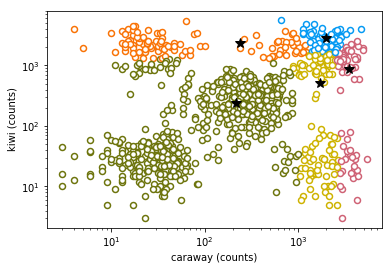

In [12]:
ctype, data, N, G, Q                   = read_data(infile)
kp, centroids, assignments, tot_sqdist = kmeans(data, Q)
for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, kp[q], centroids[q,0], centroids[q,1]))
print("final totdist = {0:.1f}".format(tot_sqdist))
visualize_data(data, centroids, assignments, T=ctype)


Here's a cheapo strategy for running K-means many times to identify a best solution, and to be able to reproduce that solution at will: we'll take advantage of being able to seed the numpy random number generator.



In [13]:
for run in range(20):
    np.random.seed(run)
    kp, centroids, assignments, tot_sqdist = kmeans(data, Q)
    print("RNG seed {0:2d}:  tot_sqdist {1:12.1f}".format(run, tot_sqdist))

iterations = 21
RNG seed  0:  tot_sqdist  350249595.5
iterations = 25
RNG seed  1:  tot_sqdist  350249595.5
iterations = 24
RNG seed  2:  tot_sqdist  350249595.5
iterations = 44
RNG seed  3:  tot_sqdist  350249595.5
iterations = 12
RNG seed  4:  tot_sqdist  350295468.0
iterations = 19
RNG seed  5:  tot_sqdist  349621756.0
iterations = 32
RNG seed  6:  tot_sqdist  350249595.5
iterations = 18
RNG seed  7:  tot_sqdist  350249595.5
iterations = 19
RNG seed  8:  tot_sqdist  350249595.5
iterations = 19
RNG seed  9:  tot_sqdist  350249595.5
iterations = 27
RNG seed 10:  tot_sqdist  349480429.7
iterations = 41
RNG seed 11:  tot_sqdist  350249595.5
iterations = 21
RNG seed 12:  tot_sqdist  350249595.5
iterations = 11
RNG seed 13:  tot_sqdist  350249595.5
iterations = 15
RNG seed 14:  tot_sqdist  350249595.5
iterations = 37
RNG seed 15:  tot_sqdist  350249595.5
iterations = 18
RNG seed 16:  tot_sqdist  350249595.5
iterations = 45
RNG seed 17:  tot_sqdist  350249595.5
iterations = 24
RNG seed 18:

With a little more work we could have python find the best one in that, but we can also do it by eye: seed 10 (or 18, which is probably the same). Let's reproduce it and see what it looks like.

iterations = 27
0   0.0680  3470.6618   879.2794
1   0.0700  1996.6857  2806.5571
2   0.1110  1686.0360   509.0631
3   0.1100   236.1091  2371.4727
4   0.6410   214.4243   236.6178
final tot_sqdist = 349480429.7


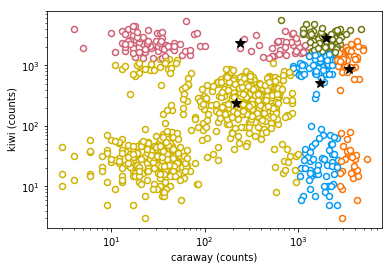

In [14]:
np.random.seed(10)
kp, centroids, assignments, tot_sqdist = kmeans(data, Q)
for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, kp[q], centroids[q,0], centroids[q,1]))
print("final tot_sqdist = {0:.1f}".format(tot_sqdist))
visualize_data(data, centroids, assignments, T=ctype)


Close enough - we'll call that a reproduction of Wiggins' result. We're having the same trouble that he did. K-means is not finding the obvious clusters in the data, even with 20 runs.

## 2. mixture negative binomial fitting

Now we'll use the same skeleton, and some of the same functions, to implement a mixture negative binomial model, and fit it iteratively with expectation maximization. 

Let's first call in some additional modules for help...

In [15]:
import scipy.stats   as stats
import scipy.misc    as misc
import scipy.special as special

We need to be able to calculate $\log P(x \mid \mu, \phi)$, the log probability of one data point given known NB parameters. The trick here is the change of variables to match what SciPy thinks the NB is, as we talked about in class and the lecture notes.

In [16]:
def logpmf_nb(x, mu, phi):
    p = 1 / (1 + mu * phi)
    r = 1 / phi
    return stats.nbinom.logpmf(x, r, p)

The expectation step corresponds to the k-means assignment step. Instead of making a hard assignment of each data point to one and only one cluster, we calculate a posterior probability $P(q \mid x, \theta)$ that the point belongs to component $q$, given our current mixture model $\theta$. The parameters of the current mixture model $\theta$ are passed around as three arrays: $\mu_q$, $\phi_q$, and `mixq[q]`.

In [17]:
def expectation_mixnb(X, mu, phi, mixq):
    """
    Input:
       X[i,g] are the data points.
       mu[q]  are the mean (mu) NB parameters, for each component q
       phi[q] are the dispersion (phi) NB parameters, for each component q
       mixq[q] are the mixture coefficients, the "prior" probability P(q) of each component
    Return nll, pp:
       nll     negative log likelihood of the current model
       pp[i,q] posterior probability that data point i belongs to component q   
    """
    N, G   = np.shape(X)
    Q, G2  = np.shape(mu)
    Q3     = len(mixq)
    assert G2 == G
    assert Q3 == Q

    pp  = np.zeros((N, Q))   # pp[i][k] = P(C=k \mid x_i)
    nll = 0
    for i in range(N):
        for q in range(Q):
            pp[i][q] = np.log(mixq[q])
            for g in range(G):
                pp[i][q] += logpmf_nb(X[i][g], mu[q][g], phi) 
        Z     = special.logsumexp(pp[i])   # Z = \log \sum_q P(X_i, q)  = \log P(X_i)
        nll  -= Z
        pp[i] = np.subtract(pp[i], Z)
        pp[i] = np.exp(pp[i])
    return nll, pp

The maximization step corresponds to the k-means update step. Instead of just calculating the centroid of the points assigned to each cluster, we estimate new maximum likelihood parameters for the mixture model, given posterior probabilities of how data points are assigned to the components.

We're told in the problem that we can assume a common dispersion $\phi = 0.3$ so we don't reestimate the $\phi_q$, only the $\mu_q$ and the mixture coefficients `mix[q]`. The reestimated $\mu_q$ are just the posterior weighted means.

In [18]:
def maximization_mixnb(X, pp):
    N,  G   = np.shape(X)
    N2, Q   = np.shape(pp)
    assert N == N2
    
    counts = np.sum(pp, axis=0)   # now counts[q=0..Q-1] are expected counts per component
    
    # Count data points i into mu[q=0..Q-1], proportional to pp[i][q]
    mu = np.zeros((Q,G))
    for i in range(N):
        for q in range(Q):
            for g in range(G):
                mu[q,g] += pp[i,q] * X[i,g]

    for q in range(Q):
        if counts[q] > 0:
            for g in range(G):
                mu[q,g] = mu[q,g] / counts[q]
        else:                               # it's harder to get counts[q] of literally zero now, but it can still happen.
            mu[q]     = sample_component(X)
            counts[q] = N / Q               # arbitrary reinitialization hack
            print("REINITIALIZED component ", q) # warn if we do it.

    mixq = np.divide(counts, N)
    return mixq, mu

We need an appropriate convergence test. We could use the total log likelihood of the data, or we could use the change in the parameters. Here we'll look at the change in the parameters $\mu_q$.

In [19]:
def difference_in_mu(mu, oldmu):
    Q, G  = np.shape(mu)
    Q2,G2 = np.shape(oldmu)
    assert Q == Q2
    assert G == G2

    delta = np.sum(np.fabs(np.subtract(mu, oldmu)))
    delta = delta / (Q*G)
    return delta

Put those pieces together into an iterative EM routine for fitting a mixture NB to our data.

As in k-means, we allow an option where we can pass the true cluster assignments `T[i]` to initialize our components there. This is useful in debugging; the true answer should be stable.

In [20]:
def fit_mixnb(X, Q, phi, T=np.zeros(0)):
    N, G   = np.shape(X)

    # initial guesses
    if len(T) > 0:
        mu, mixq = update_kmeans(X, T, K)  # we're using the k-means update to initialize at the true clusters (debugging)
    else:
        mu = np.zeros((Q,G))
        for q in range(Q):
            mu[q] = sample_component(X)
            mixq = np.full(Q, 1.0/Q)

    iteration = 0
    while True:
        nll, pp  = expectation_mixnb(X, mu, phi, mixq)        
        oldmu    = mu.copy()
        mixq, mu = maximization_mixnb(X, pp)
        delta    = difference_in_mu(mu, oldmu)
        iteration += 1
        print("iteration {0}  nll {1:.1f}  delta {2:.3f}".format(iteration, nll, delta))
        if delta < 1.0: break
              
    nll, pp  = expectation_mixnb(X, mu, phi, mixq)
    assignments = np.zeros(N).astype(int)
    for i in range(N):
        assignments[i] = np.argmax(pp[i])

    return mixq, mu, assignments, nll


Does it work? (You can uncomment a print statement in `fit_mixnb` to see some output about how each iteration is doing.)

iteration 1  nll 42796.5  delta 155.623
iteration 2  nll 16081.0  delta 35.820
iteration 3  nll 15768.4  delta 45.347
iteration 4  nll 15566.2  delta 38.922
iteration 5  nll 15488.5  delta 21.100
iteration 6  nll 15471.8  delta 8.628
iteration 7  nll 15469.1  delta 3.426
iteration 8  nll 15468.6  delta 1.445
iteration 9  nll 15468.5  delta 0.668
0   0.3554  1626.0643  1627.5301
1   0.0047     8.2405    22.9426
2   0.0104    32.0268    22.0271
3   0.2040    31.7664    32.1097
4   0.4255   332.7552   328.9785
final NLL = 15468.4


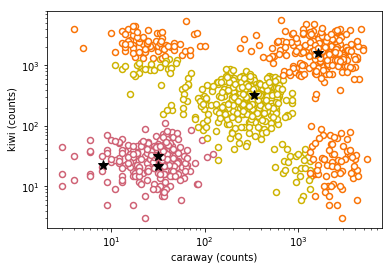

In [21]:
phi = 0.3
np.random.seed(1)  
mixq, mu, assignments, nll = fit_mixnb(data, Q, phi)

for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, mixq[q], mu[q,0], mu[q,1]))
print("final NLL = {0:.1f}".format(nll))

visualize_data(data, mu, assignments, T=ctype)


Meh. Sort of. Still prone to local optima though!

We have to run a bunch of times, and take the best. The total negative log likelihood of each 'optimal' model fit is a good statistic to compare; smaller is better. This takes a while, and warms up the fans on your laptop:

In [22]:
for run in range(20):
    np.random.seed(run)
    mixq, mu, assignments, nll = fit_mixnb(data, Q, phi)
    print("RNG seed {0:2d}:  nll {1:12.1f}".format(run, nll))

iteration 1  nll 20495.2  delta 447.606
iteration 2  nll 14900.4  delta 199.980
iteration 3  nll 14088.0  delta 34.610
iteration 4  nll 14012.5  delta 3.832
iteration 5  nll 14009.0  delta 0.780
RNG seed  0:  nll      14008.8
iteration 1  nll 42796.5  delta 155.623
iteration 2  nll 16081.0  delta 35.820
iteration 3  nll 15768.4  delta 45.347
iteration 4  nll 15566.2  delta 38.922
iteration 5  nll 15488.5  delta 21.100
iteration 6  nll 15471.8  delta 8.628
iteration 7  nll 15469.1  delta 3.426
iteration 8  nll 15468.6  delta 1.445
iteration 9  nll 15468.5  delta 0.668
RNG seed  1:  nll      15468.4
iteration 1  nll 37826.7  delta 319.221
iteration 2  nll 15724.1  delta 18.165
iteration 3  nll 15697.1  delta 6.719
iteration 4  nll 15681.3  delta 7.133
iteration 5  nll 15652.0  delta 10.608
iteration 6  nll 15584.9  delta 19.006
iteration 7  nll 15431.7  delta 33.901
iteration 8  nll 15155.5  delta 53.757
iteration 9  nll 14866.5  delta 60.121
iteration 10  nll 14722.6  delta 36.027
itera

KeyboardInterrupt: 

Looks like we've got some distinct classes of alternative solutions in there. The best is 14008.8, and we found a solution at that NLL several times. Odds are it's the same solution each time. Let's have a look:

In [ ]:
np.random.seed(13)
mixq, mu, assignments, nll = fit_mixnb(data, Q, phi)
for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, mixq[q], mu[q,0], mu[q,1]))
print("final NLL = {0:.1f}".format(nll))
visualize_data(data, mu, assignments, T=ctype)


Nailed it.  (The positions of the clusters, anyway. There's a little bit of misassignment of points along the boundaries between clusters, which we should expect, because the clusters slightly overlap.)

The fitted mean expression levels of _Caraway_ and _Kiwi_ for each component are in the table above the figure, with their relative proportions.

The true answer was:

```
  0  0.1    30  2000 
  1  0.2  2000  2000 
  2  0.4   300   300 
  3  0.2    30    30 
  4  0.1  2000    30 
```

which you can see in the best fit, with the components permuted.


## 3. find a simple fix for k-means

k-means implicitly assumes clusters shaped as spherical Gaussians, with equal variance, with uniform mass (each cluster has about the same number of points assigned to it). We can't do much about the equal variance and uniform mass assumptions, unless we move away from k-means to fitting an explicit mixture model like we just did. But we do have freedom to change the basis of the space that we're calculating Euclidean distances in, and this choice can have big effects on k-means.

For instance, here the fact that we've been plotting _Caraway_ vs _Kiwi_ counts on log-log plots is a big clue. These data look like nice clusters in _log_ space, not in their raw counts. 

We left an option `do_logspace_distance` in our k-means implementation; now let's use it. 

In [ ]:
do_logspace_distance = True
for run in range(20):
    np.random.seed(run)
    kp, centroids, assignments, tot_sqdist = kmeans(data, Q)
    print("RNG seed {0:2d}:  totdist {1:12.1f}".format(run, tot_sqdist))

The best (789.6) solution comes up several times. Let's look at one:

iterations = 21
0   0.1080   218.0833  2292.9537
1   0.6390   214.9781   233.3052
2   0.1160  1685.8017   562.2931
3   0.0680  1932.6912  2969.1324
4   0.0690  3455.6667   890.4638
final totdist = 350249595.5


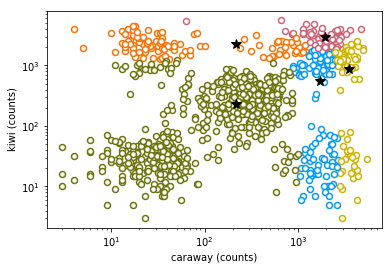

In [24]:
np.random.seed(0)
kp, centroids, assignments, totdist = kmeans(data, Q)
for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, kp[q], centroids[q,0], centroids[q,1]))
print("final totdist = {0:.1f}".format(totdist))
visualize_data(data, centroids, assignments, T=ctype)


The next best (792.4) solutions are also fine:

In [ ]:
np.random.seed(19)
kp, centroids, assignments, totdist = kmeans(data, Q)
for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, kp[q], centroids[q,0], centroids[q,1]))
print("final totdist = {0:.1f}".format(totdist))
visualize_data(data, centroids, assignments, T=ctype)


And so are the 793.3 and 796.2 solutions (RNG seeds 19 and 13, for example; not shown) which means that 20/20 k-means runs are finding an essentially correct clustering now. Calculating the distance in the log-transformed space made a big difference.